# Static potential with fermions

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import qiskit

from scipy.sparse.linalg import eigsh
from qiskit.quantum_info import Statevector
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("../../") # go to parent dir
from itertools import permutations,product
from tqdm.notebook import tqdm
import datetime
import scipy.sparse as sp
from time import perf_counter

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes,inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import matplotlib as mpl

from Hamiltonian_QED_sym import HamiltonianQED_sym
from Hamiltonian_QED_oprt import HamiltonianQED_oprt
from HC_Lattice import HCLattice
from Ansaetze import Ansatz
import primme

#local import
from Observables import *
from Fidelity_func import *

#Qiskit import
from qiskit import QuantumCircuit, QuantumRegister,ClassicalRegister
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_distribution
from qiskit.circuit import Parameter
import qiskit.quantum_info as qinf
from qiskit.primitives import Sampler, Estimator
#from qiskit_ibm_runtime import Estimator, Session, QiskitRuntimeService, Options
from qiskit_algorithms.state_fidelities import ComputeUncompute
from qiskit.quantum_info import SparsePauliOp, Pauli, Operator
from sys import stdout
from qiskit_algorithms.optimizers import NFT,SLSQP,COBYLA,ADAM,SPSA,QNSPSA,CG,GradientDescent,L_BFGS_B
from qiskit.quantum_info.states import DensityMatrix
import qiskit.quantum_info as qinf
from qiskit.quantum_info import entropy
from qiskit_algorithms.eigensolvers import VQD
from qiskit_algorithms.minimum_eigensolvers import VQE


/var/folders/08/fx8gnyrx18jggry6_s4cbtz40000gn/T/ipykernel_12107/1953758291.py:23: DeprecationWarning: Please use `aslinearoperator` from the `scipy.sparse.linalg` namespace, the `scipy.sparse.linalg.interface` namespace is deprecated.
  import primme


In [3]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes,inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import re
import matplotlib as mpl
mpl.rcParams["font.family"] = "serif"
mpl.rcParams["font.size"] = "14"
mpl.rcParams["font.serif"] = "STIX"
mpl.rcParams["mathtext.fontset"] = "stix"

# Set the font family to a serif font available on your system (e.g., 'Times New Roman')
plt.rcParams['font.serif'] = ['Times New Roman']

# Disable TeX rendering
plt.rcParams['text.usetex'] = False

def set_size(width, fraction=1):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float
            Document textwidth or columnwidth in pts
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy

    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure (in pts)
    fig_width_pt = width * fraction

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio

    fig_dim = (fig_width_in, fig_height_in)

    return fig_dim

##### Hamiltonian

[{(0, 0): -1, (0, 1): 1} {(0, 0): -1, (1, 0): 1} {(0, 0): -1, (2, 1): 1}] {1.0, 2.23606797749979}


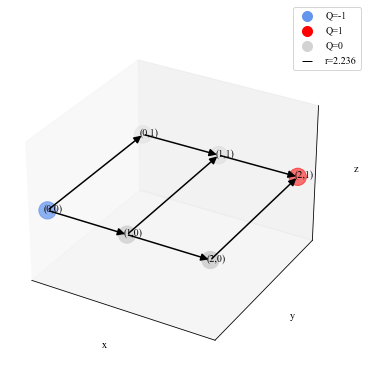

In [4]:
#class input parameters:
n_sites = [3,2]#how many sites for every dimension
g=1
fact_e_op = 1
fact_b_op = 1
m=2
omega=1
l=1
L=8
rotors = False
lambd = 1000
encoding = 'gray' ##'ed'#
magnetic_basis=False
pbc=False
puregauge = False
static_charges_values =None#{(0,0):1,(1,0):-1}#TODO: no conditions applied, like charge conservation, etc. For conditions see func_qstatic_dist
display_hamiltonian=False
e_op_out_plus=False #if E out of site n has plus sign
sparse_pauli =False #false for circuit ansatz
#exact diagonalisation parameters:
threshold = 1e-12
num_eigs = 1

#lattice
latt = HCLattice(n_sites,pbc=pbc,puregauge=puregauge)

#static charge
latt.func_qstatic_dist()#charge=(1,0))
static_charges_values_input = latt.distances_coord
print(static_charges_values_input,set(latt.r_list))
qstat=static_charges_values_input[-1]

#qstat={(0,0):-1,(2,1):1}
#latt.func_qstatic_dist((2,1),ch_val=2)


#[latt.draw_graph_func(gauss_law_fig=False,static_charges=st) for st in static_charges_values_input]

latt.draw_graph_func(gauss_law_fig=False,static_charges=qstat)#,savefig_dir='.')

In [5]:
from sympy import Symbol
e_op_free_input=['q_10', 'q_20', 'q_21', 'q_11', 'q_01','E_10y', 'E_20y',]#if fermions then also put charges!
e_op_free_input=[Symbol(e) for e in e_op_free_input]

# Creating a configuration dictionary with common inputs
config = {
    'latt': latt,
    'n_sites': n_sites,
    'l':l,
    'L':L,
    'encoding':encoding,
    'magnetic_basis': magnetic_basis,
    'pbc': pbc,
    'puregauge': puregauge,
    'static_charges_values': qstat,
    'e_op_out_plus': e_op_out_plus,
    'e_op_free_input':e_op_free_input
}
hamilt_sym = HamiltonianQED_sym(config,display_hamiltonian=False)
class_H_oprt = HamiltonianQED_oprt( config,hamilt_sym, sparse_pauli=sparse_pauli)


ngauge = class_H_oprt.len_e_op
# if puregauge:
#     n_qubits_f = 0
# else:
#     n_qubits_f = np.prod(latt.n_sites)

# n_qubits =int(np.ceil(np.log2(2 * l+ 1)))

HamiltonianQED_sym: Initializing...
> Gauss law equations solved
> e_op_free and u_op_free built
>> Gauss law applied and Hamiltonian built.  Execution time: 0.04296398162841797 seconds
HamiltonianQED_oprt: Initializing...
> e_op_free and u_op_free built
> Pauli strings built
Hamiltonian_el_pauli done
>> Hamiltonian built.  Execution time: 4.222714185714722 seconds
>> Suppression term built.  Execution time: 0.015449047088623047 seconds


In [6]:
class_H_oprt.qop_list[::-1]+class_H_oprt.uop_list[::-1]#order of operators in tensor product and on circuit little endian ..q2q1q0

[q_01, q_11, q_21, q_20, q_10, q_00, U_20y, U_10y]

In [7]:

#print('or charges')
for i,k in enumerate(class_H_oprt.uop_list+class_H_oprt.qop_list):
    print(f'qubit{i}:{k}')

qubit0:U_10y
qubit1:U_20y
qubit2:q_00
qubit3:q_10
qubit4:q_20
qubit5:q_21
qubit6:q_11
qubit7:q_01


##### Quantum circuit: with fermions

Total n.er of qubits: 10
Total n.er of CNOT gates (Toffoli are decomposed): 126
Total n.er of parameters: 18
CNOT depth: 54


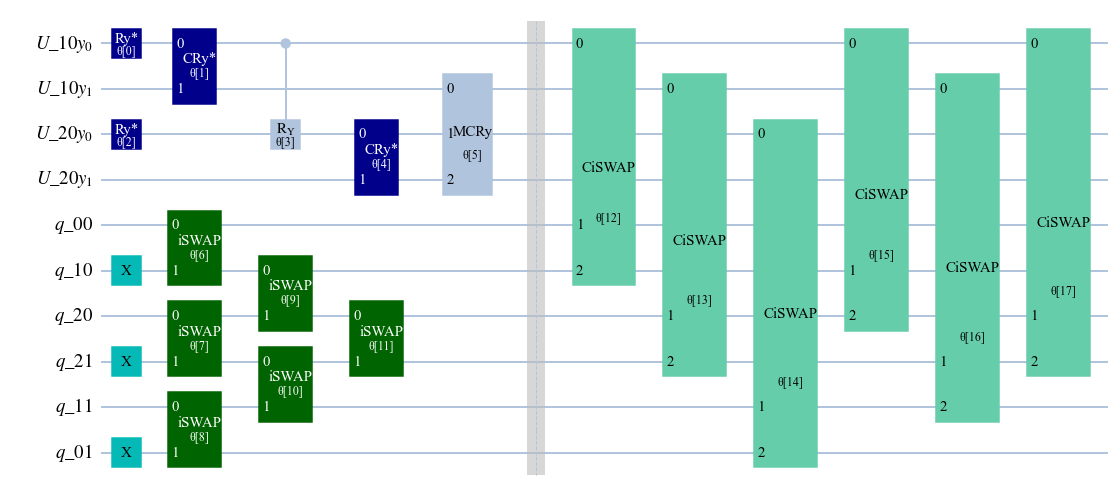

In [8]:
nlayers= 1
entanglement='linear'#triangular,linear,full
rzlayer=False
ngauge = class_H_oprt.len_e_op
if puregauge:
    n_qubits_f = 0
else:
    n_qubits_f = np.prod(latt.n_sites)

n_qubits =int(np.ceil(np.log2(2 * l+ 1)))


ansatz_class = Ansatz(l,ngauge,nfermions=n_qubits_f,gauge_list= class_H_oprt.uop_list,ferm_list=class_H_oprt.qop_list)
qc_tot2,first_layer_par = ansatz_class.gauge_fermion_circuit(entanglement=entanglement,rzlayer=rzlayer,nlayers=nlayers)
print('Total n.er of qubits:',qc_tot2.num_qubits)
print('Total n.er of CNOT gates (Toffoli are decomposed):',dict(qc_tot2.decompose(reps=6).count_ops())['cx'])
print('Total n.er of parameters:',qc_tot2.num_parameters)
depth = qc_tot2.decompose(reps=4).depth(lambda x: x[0].num_qubits == 2)
print("CNOT depth:",depth)
#print(ansatz_class.first_layer_par)
#parameter counts
#ansatz_class.parameters_count(n_qubits,ngauge)
qc_tot2.draw('mpl',fold=50,
             style=ansatz_class.style)
# qc_tot2.decompose(reps=6).draw('mpl',fold=50,
#              style=ansatz_class.style)

In [9]:
print("Total numer of gates",qc_tot2.decompose(reps=6).count_ops())

Total numer of gates OrderedDict([('u', 181), ('cx', 126), ('barrier', 1)])


##### ED

In [10]:
#ED
import scipy.sparse as sp
Hamiltonian_Pauli_tot = class_H_oprt.get_hamiltonian(g_var=g, m_var=m, omega=omega,fact_b_op=fact_b_op,fact_e_op=fact_b_op,lambd=lambd)
#memory sparse matrix
#print((Hamiltonian_Pauli_tot.data.nbytes + Hamiltonian_Pauli_tot.indptr.nbytes + Hamiltonian_Pauli_tot.indices.nbytes)/1000**3,'Gb')
if encoding=='gray' and not sparse_pauli:
    Hamiltonian_Pauli_tot = Hamiltonian_Pauli_tot.to_matrix(sparse=True)
    if ngauge:
        h_b_sparse = class_H_oprt.hamiltonian_mag_pauli.to_matrix(sparse=True) #plaquette
    else:
        h_b_sparse = 0
elif encoding=='ed':
    Hamiltonian_Pauli_tot = sp.csr_matrix(Hamiltonian_Pauli_tot)
    if ngauge:
        h_b_sparse =sp.csr_matrix(class_H_oprt.hamiltonian_mag_pauli)
    else:
        h_b_sparse =0

#** Exact diagonalisation
spectrum, eigenvectors_matrix =primme.eigsh(Hamiltonian_Pauli_tot,k=num_eigs,which="SA")#,ncv = 30)
#spectrum
idx = spectrum.argsort()
spectrum = spectrum[idx]
eigenvectors_matrix = eigenvectors_matrix[:,idx]

ed_val = []
for kk in range(num_eigs):
    ed_val.append(dict([(str(np.binary_repr(i, width = (ngauge*n_qubits+n_qubits_f))),np.abs(eigenvectors_matrix[:,kk][i])**2) for i in range(2**(ngauge*n_qubits+n_qubits_f)) if np.abs(eigenvectors_matrix[:,kk][i])**2>1e-10]))

eig0cj = sp.csr_matrix(eigenvectors_matrix[:,0]).transpose().conjugate()
eig0= sp.csr_matrix(eigenvectors_matrix[:,0])

#chiral condensate
chiral_op = 0.5 * (class_H_oprt.I - class_H_oprt.Z) #phi^dag phi|0>=0 and phi^dag phi|1>=1|1> so 0.5*(I-Z) is the chiral condensate


# if ngauge:
#     plaq = (eig0*h_b_sparse*eig0cj/len(latt.plaq_list) ).toarray()[0][0].real
    #same as: ((eig0cj.toarray()[:,0]).dot((h_b_sparse).dot((eig0.toarray()[0,:]))).real)/len(latt.plaq_list)
print(f'spectrum ED for charge{qstat}:',spectrum)#'plaq',plaq)

#***** total charge
if not puregauge:
    tot_charge_op = total_charge_op(latt,class_H_oprt, puregauge,encoding).to_matrix(sparse=True) if encoding=='gray' else total_charge_op(latt,class_H_oprt, puregauge,encoding)
    tot_charge  =  (eig0*tot_charge_op*eig0cj).toarray()[0][0].real
    print('total charge <GS|Q|GS>:',np.round(tot_charge,8))


spectrum ED for charge{(0, 0): -1, (2, 1): 1}: [-5.78215518]
total charge <GS|Q|GS>: 0.0


psi_0 ED:2D_3x2mbasisFalse puregaugeFalse g1 pbcFalse l1_factE1_factB1


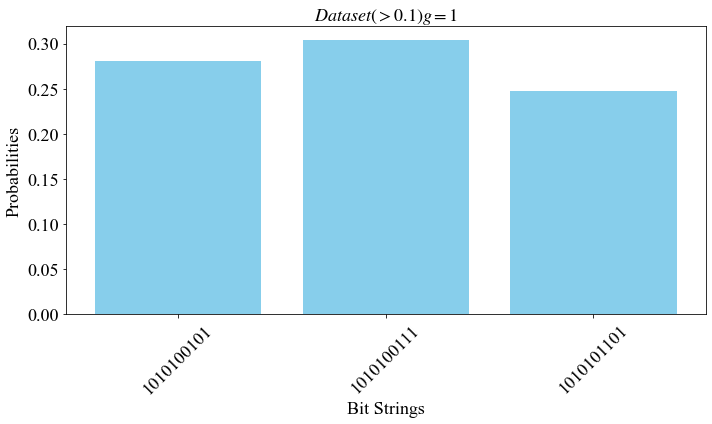

In [11]:
thrsl =1e-1
ed_e0_dict =dict([(str(np.binary_repr(i, width = (ngauge*n_qubits+n_qubits_f))),np.abs(eigenvectors_matrix[:,0][i])**2) for i in range(2**(ngauge*n_qubits+n_qubits_f)) if np.abs(eigenvectors_matrix[:,0][i])**2>thrsl])

print(f'psi_0 ED:{latt.dims}D_'+'x'.join(map(str,latt.n_sites))+f'mbasis{magnetic_basis} puregauge{puregauge} g{g} pbc{pbc} l{l}_factE{fact_e_op}_factB{fact_b_op}')
plt.figure(figsize=(10, 6))
plt.bar(list(ed_e0_dict.keys()), list(ed_e0_dict.values()), color='skyblue')
plt.xlabel('Bit Strings',fontsize=18)
plt.ylabel('Probabilities',fontsize=18)
plt.title(f'$Dataset (> {thrsl}) g={g}$',fontsize=18)#beta (1/g^2)={np.round(1/g**2,5)}')
plt.xticks(rotation=45,fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()
plt.show()

('1010100101', 0.28105519964645825)


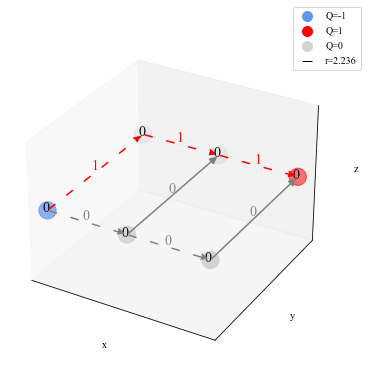

('1010100111', 0.30387203783908934)


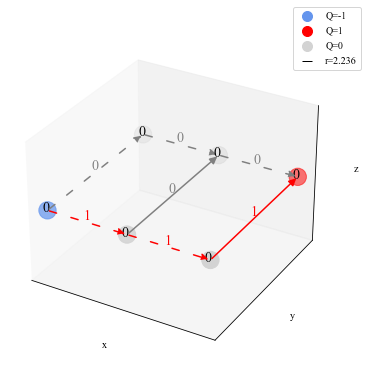

('1010101101', 0.247097067966917)


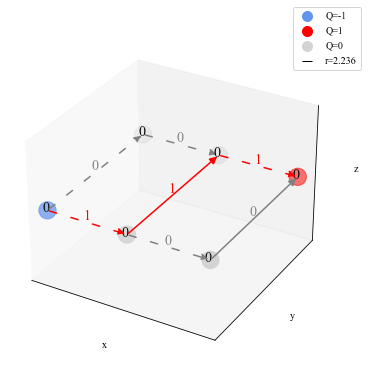

In [12]:
# for i,k in enumerate(class_H_oprt.eop_list+class_H_oprt.qop_list):
#     print(f'qubit{i}:{k}')

for key,val in ed_e0_dict.items():
    conf = class_H_oprt.eop_config_from_string(key)
    print((key,val))
    latt.draw_graph_func(gauss_law_fig=True,e_op_free=class_H_oprt.e_op_free,static_charges=qstat,weight=conf,savefig_dir='.',figname=f'conf_{key}_prob_{val}_puregauge.png')

## VQE

##### Input parameteres circuit

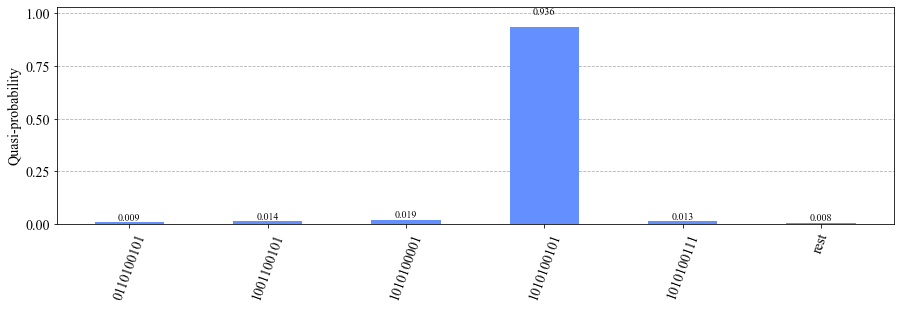

In [13]:
import re
#initial point focused on the vacuum state
initial_point = np.zeros(qc_tot2.num_parameters)
for k,i in enumerate([int(re.search(r'\d+', str(param)).group()) for param in qc_tot2.parameters]):
    initial_point[k]=np.pi if i in first_layer_par else np.pi/8*(2*np.random.rand(1)-1.0)[0]  #strong coupling: first_layer_par+[8,9,11]

plot_distribution(Statevector(qc_tot2.assign_parameters(initial_point)).probabilities_dict(),figsize=(15, 4),number_to_keep=5)


In [14]:
#Input parameters for VQD
from qiskit.primitives import Sampler, Estimator#,BackendEstimator,BackendSampler
#from qiskit_aer.primitives import Estimator as AerEstimator
nshots =None#10000

estimator = Estimator()
sampler = Sampler()

#fidelity = ComputeUncompute(sampler)

aux_operators =None#[class_H_oprt.hamiltonian_mag_pauli,] if ngauge else None
Hamiltonian_Pauli_tot_vqd = class_H_oprt.get_hamiltonian(g_var=g, m_var=m, omega=omega,fact_b_op=fact_b_op,fact_e_op=fact_b_op,lambd=0).simplify()
# norm = np.sqrt(sum([coef ** 2 for coef in Hamiltonian_Pauli_tot_vqd.coeffs]))'ADAM
# Hamiltonian_Pauli_tot_vqd = 1/norm*Hamiltonian_Pauli_tot_vqd

iterations =2000
if nshots:
    optimizer=NFT(maxiter=iterations,maxfev=3*iterations+500) #NFT,SLSQP,COBYLA,ADAM,SPSA,QNSPSA,CG,GradientDescent,L_BFGS_B
    estimator.set_options(shots=nshots)
else:
    optimizer = SLSQP(maxiter=iterations)

print(estimator.options,optimizer)
ansatz = qc_tot2

# #*** initial point
# val_init = np.pi/4
# #initial_point=[val_init*(2*np.random.rand(ansatz.num_parameters)-1.0) for kkk in range(num_eigs)]
# initial_point=val_init*(2*np.random.rand(ansatz.num_parameters)-1.0)

# initial_point

Options() <qiskit_algorithms.optimizers.slsqp.SLSQP object at 0x7fc43ca94df0>


In [15]:
print("Partition a SparsePauliOp into sets of commuting Pauli strings:",len(Hamiltonian_Pauli_tot_vqd.group_commuting()))

Partition a SparsePauliOp into sets of commuting Pauli strings: 8


##### Single run

In [16]:

#callback function
E_data = [[] for k in range(num_eigs)]
Fidelity = [[] for k in range(num_eigs)]
def callback(eval_count, parameters, mean, meta):
    now = datetime.datetime.now()
    stdout.write("eig: %d/%d -> its %4d \r"%(1,num_eigs,eval_count)) # assuming SPSA
    stdout.flush()
    # E_data[1-1].append([len(E_data[1-1]),mean,meta])
    # #fidelity
    # vqd_states = [ansatz.assign_parameters(parameters) for i in range(num_eigs)]
    # vqd_fid_states =[qinf.Statevector.from_instruction(i) for i in vqd_states]
    # ed_fid_states =[Statevector(eigenvectors_matrix[:,i]) for i in range(num_eigs)]
    # Fidelity[1-1].append([qinf.state_fidelity(vqd,ed) for vqd,ed in zip(vqd_fid_states,ed_fid_states)])

    if eval_count==1:
        E_data[1-1].append([len(E_data[1-1]),mean,meta])
        #fidelity
        vqd_states = [ansatz.assign_parameters(parameters) for i in range(num_eigs)]
        vqd_fid_states =[qinf.Statevector.from_instruction(i) for i in vqd_states]
        ed_fid_states =[Statevector(eigenvectors_matrix[:,i]) for i in range(num_eigs)]
        Fidelity[1-1].append([qinf.state_fidelity(vqd,ed) for vqd,ed in zip(vqd_fid_states,ed_fid_states)])

    if eval_count>1 and mean<E_data[1-1][-1][1]:#append only if lower energy
        #energy
        E_data[1-1].append([len(E_data[1-1]),mean,meta])
        #fidelity
        vqd_states = [ansatz.assign_parameters(parameters) for i in range(num_eigs)]
        vqd_fid_states =[qinf.Statevector.from_instruction(i) for i in vqd_states]
        ed_fid_states =[Statevector(eigenvectors_matrix[:,i]) for i in range(num_eigs)]
        Fidelity[1-1].append([qinf.state_fidelity(vqd,ed) for vqd,ed in zip(vqd_fid_states,ed_fid_states)])
        #print(now, "*** 1" ,f'E_{1-1} data:',E_data[1-1][-1],'Fid.:',Fidelity[1-1][-1], "\n",flush=True)


vqe=VQE(estimator, ansatz, optimizer,initial_point=initial_point,  callback=callback)
result = vqe.compute_minimum_eigenvalue(operator = Hamiltonian_Pauli_tot_vqd,aux_operators = aux_operators)# Hamiltonian + auxiliary operator
vqd_values = result.eigenvalue

print(vqd_values)

#eigenvectors
vqd2_eigenstates = []
tmp = result.optimal_circuit.copy()

tmp.measure_all()
opt_pt =list(result.optimal_parameters.values())
res = sampler.run(tmp, opt_pt).result()

vqd2_eigenstates.append({x:round(y,6) for x,y in res.quasi_dists[0].binary_probabilities().items() if y>1e-7})
tmp.remove_final_measurements()


-5.48726094357620655 


Options()
E_i ED vs VQE test:2D_3x2mbasisFalse puregaugeFalse g1 pbcFalse l1_factE1_factB1_m2_Omega1iterations2000 entang.linear optim. SLSQP
E_0(ED)= -5.78215518
E_0(VQE)= -5.4872609435762065
last point of callback data: [145, -5.487260943579212, {}]
Fidelity (|psi_VQDXpsi_ED|^2):
E_0: 0.9180842852173494
Check if in VQE sol. there are unphysical states: Gauge fields: ['10'] Fermions: only zero charge are considered physical
E_0 all physical states reached gauge fields: OK!
E_0 all physical states reached fermions: OK!
Parameters: [ 2.76526322 -1.0536782   2.92600506  0.13842706 -0.04091242  0.1104679
 -0.01265901  0.01136562 -0.04596184  1.42264337  3.12780983 -0.07117451
  1.75078797 -1.50387358 -0.18685476 -2.69900057 -0.1459585   0.99945078]


Text(0.5, 0, 'iterations')

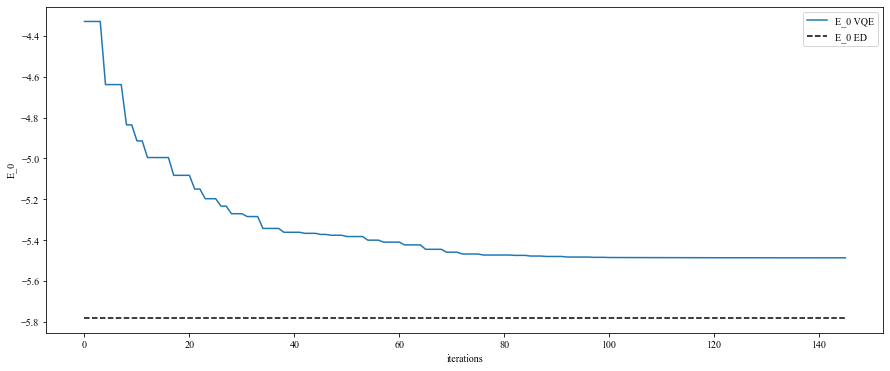

In [17]:
#print results
print(estimator.options)
print(f'E_i ED vs VQE test:{latt.dims}D_'+'x'.join(map(str,latt.n_sites))+f'mbasis{magnetic_basis} puregauge{puregauge} g{g} pbc{pbc} l{l}_factE{fact_e_op}_factB{fact_b_op}_m{m}_Omega{omega}iterations{iterations} entang.'+entanglement+' optim. '+
[i for i in ['NFT','SLSQP','COBYLA','ADAM','SPSA','GradientDescent','CG','L_BFGS_B','P_BFGS','SciPyOptimizer','AQGD','CustomNFT'] if i in str(optimizer)][0])
#print('Q_static:',qstat)
#** Print results
for kk,evalu in enumerate(spectrum[:1]):
        if evalu<900:# only physical states, 1000 corresponds to factor of penalty term
            print(f'E_{kk}(ED)=',round(evalu,8))#,[(str(np.binary_repr(i, width = (ngauge*n_qubits))),round(np.abs(eigenvectors_matrix[:,kk][i])**2,6)) for i in range(2**(ngauge*n_qubits)) if np.abs(eigenvectors_matrix[:,kk][i])**2>1e-4])
            print(f'E_{kk}(VQE)=',vqd_values.real)#,vqd2_eigenstates[kk])

if nshots:
    print('last point of callback data:',E_data[0][-1][1:],'std. dev.',np.sqrt(E_data[0][-1][-1]['variance']/E_data[0][-1][-1]['shots']))

    # print('Check if the variational result-err. is within the exact result:E_0(VQE)-std.dev.(',
    #     (E_data[0][-1][1]-(np.sqrt(E_data[0][-1][-1]['variance']/E_data[0][-1][-1]['shots']))),') <= E_0(ED) (',spectrum[0],')')
else:
    print('last point of callback data:',E_data[0][-1])

# #** Fidelity final (two options, same result)
#fid=fidelity_func(result,eigenvectors_matrix,num_eigs)
fid = Fidelity[0][-1]
print('Fidelity (|psi_VQDXpsi_ED|^2):')
[print(f'E_{i}:',fd) for i,fd in enumerate(fid)]


#**Check if there are unphysical states
gray_unph = []
for i in range(2 * l + 1, 2**int(np.ceil(np.log2(2 * l+ 1)))):
    gray_decimal = i ^ (i >> 1)
    gray_unph.append("{0:0{1}b}".format(gray_decimal,int(np.ceil(np.log2(2 * l+ 1)))))

ferm_q0 = [''.join(i) for i in permutations(['0','1']*(n_qubits//2),n_qubits)]

print('Check if in VQE sol. there are unphysical states: Gauge fields:',gray_unph,'Fermions: only zero charge are considered physical')
for i in range(num_eigs):
    if ngauge:
        for vqd_res in [string[-(ngauge*n_qubits):][i:i+int(np.ceil(np.log2(2 * l+ 1)))] for string in vqd2_eigenstates[i].keys() for i in range(0, len(string[-(ngauge*n_qubits):]), int(np.ceil(np.log2(2 * l+ 1))))]:
            if vqd_res in gray_unph:
                print('unphysical state reached for gauge fields')
                break
        else:
            print(f'E_{i} all physical states reached gauge fields: OK!')
    if n_qubits_f:
        for vqd_res in [string[:n_qubits_f] for string in vqd2_eigenstates[i].keys() ]:

            if vqd_res in ferm_q0:
                print('unphysical state reached for fermions')
                break
        else:
            print(f'E_{i} all physical states reached fermions: OK!')

#parameters
print('Parameters:',result.optimal_point)

fig =plt.figure(figsize=(15,6))
plt.plot([i[0] for i in E_data[0]],[i[1] for i in E_data[0]],label=f'E_{0} VQE')
plt.hlines(spectrum[0],E_data[0][0][0],E_data[0][-1][0],linestyles='dashed',color='black',label=f'E_{0} ED')

plt.legend()
plt.ylabel('E_0')
plt.xlabel('iterations')

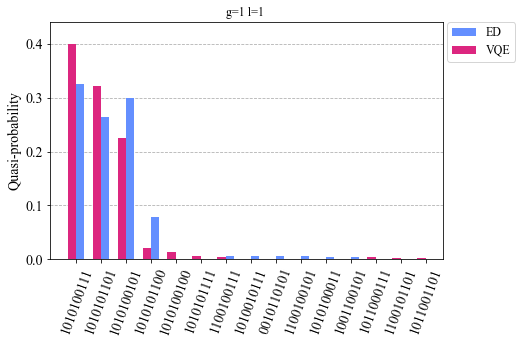

In [18]:
width=510
fig_hist=plot_distribution([ed_val[0], vqd2_eigenstates[0]], figsize=set_size(width),legend=['ED','VQE'] ,bar_labels=False,number_to_keep=10,sort='value_desc',
               title=f'g={g} l={l} ')
fig_hist
#fig_hist.savefig(f'plots/E_0_ED_vs_VQD_test:{latt.dims}D_'+'x'.join(map(str,latt.n_sites))+f'mbasis{magnetic_basis}_puregauge{puregauge}_g{g}_pbc{pbc}_l{l}_nlayers{nlayers}_iterations{iterations}.png',dpi=600, bbox_inches="tight")


('1010100101', 0.220636)


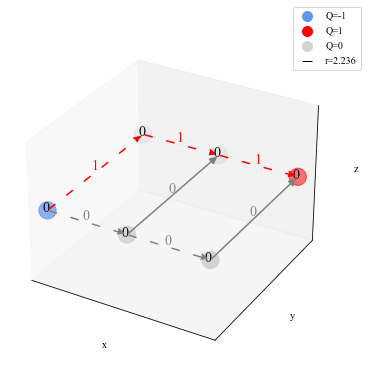

('1010100111', 0.393644)


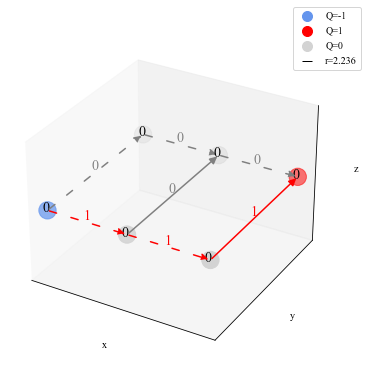

('1010101101', 0.316859)


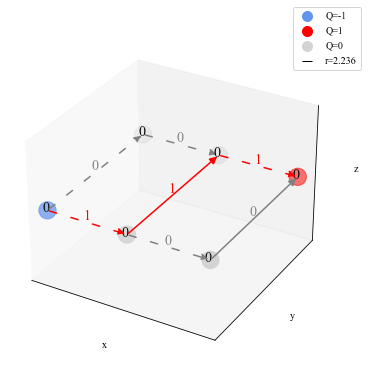

In [19]:
for key,val in {key:val for key,val in vqd2_eigenstates[0].items() if val>1e-1}.items():
    conf = class_H_oprt.eop_config_from_string(key)
    print((key,val))
    latt.draw_graph_func(gauss_law_fig=True,e_op_free=class_H_oprt.e_op_free,static_charges=qstat,weight=conf)#,savefig_dir='Images/',figname=f'config_g{g}_l{l}_E_0_VQD_{key}_probab{np.round(val,2)}.png')

## Read datafile

In [20]:
def read_datafile(filetxt):
    filename = filetxt  # Replace this with the actual path to your file

    # Define regular expressions to extract the required data
    pattern_ed = r'E_0\(ED\)= (-?\d+\.\d+)'
    pattern_vqd = r'E_0\(VQE\)= (-?\d+\.\d+)'
    pattern_vqd_data = r'data: \[(-?\d+\.\d+)'
    pattern_std_dev = r'std\. dev\. (-?\d+\.\d+)'
    pattern_fidelity = r'E_0: (\d+\.\d+)'
    pattern_parameters = r'Parameters: \[([\s\d\.\-\+eE]+)\]'

    ed_values = []
    vqd_values = []
    std_dev_values = []
    fidelity_values = []
    parameters_values = []

    with open(filename, 'r') as file:
        data = file.read()

        # Extract E_0(ED) values
        ed_values = np.array(list(map(float, re.findall(pattern_ed, data))))

        # Extract E_0(VQD) values
        vqd_values = np.array(list(map(float, re.findall(pattern_vqd, data))))

        # Extract std. dev. values
        std_dev_values = np.array(list(map(float, re.findall(pattern_std_dev, data))))

        # Extract Fidelity (|psi_VQDXpsi_ED|^2) values
        fidelity_values = np.array(list(map(float, re.findall(pattern_fidelity, data))))

        # Extract Parameters values
        parameters_matches = re.finditer(pattern_parameters, data)
        parameters_list = [np.array(list(map(float, match.group(1).split()))) for match in parameters_matches]

    return ed_values, vqd_values, std_dev_values, fidelity_values, parameters_list

In [26]:
ed_values, vqd_values_noise, std_dev_values_noise,fidelity_values_noise,param_values=read_datafile(f'static_potential_3x2_m2_omega1_l1.txt')
dict_eigst=Statevector(qc_tot2.assign_parameters(param_values[1])).probabilities_dict()

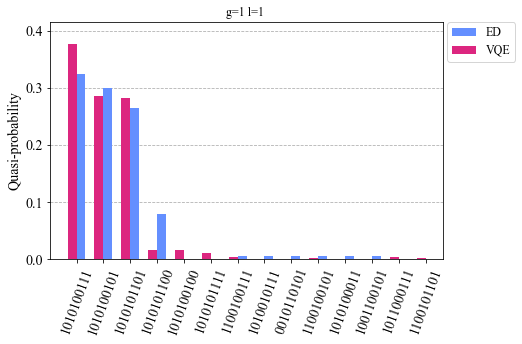

In [27]:
from qiskit.visualization import plot_distribution
width=510
fig_hist=plot_distribution([ed_val[0], dict_eigst], figsize=set_size(width),legend=['ED','VQE'] ,bar_labels=False,number_to_keep=10,sort='value_desc',
               title=f'g={g} l={l} ')
               #,filename=f'plots/E_0_ED_vs_VQD_test:{latt.dims}D_'+'x'.join(map(str,latt.n_sites))+f'mbasis{magnetic_basis}_puregauge{puregauge}_g{g}_pbc{pbc}_l{l}_nlayers{nlayers}_iterations{iterations}.png')
fig_hist
#fig_hist.savefig(f'plots/E_0_ED_vs_VQD_test:{latt.dims}D_'+'x'.join(map(str,latt.n_sites))+f'mbasis{magnetic_basis}_puregauge{puregauge}_g{g}_pbc{pbc}_l{l}_nlayers{nlayers}_iterations{iterations}.png',dpi=600, bbox_inches="tight")


('1010100101', 0.28087129990629334)


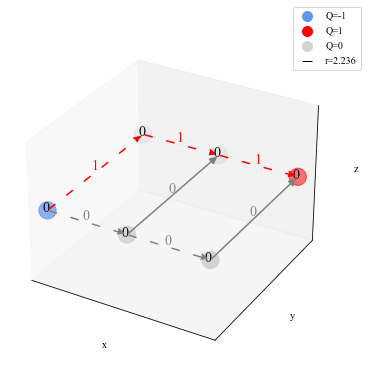

('1010100111', 0.37082962178820955)


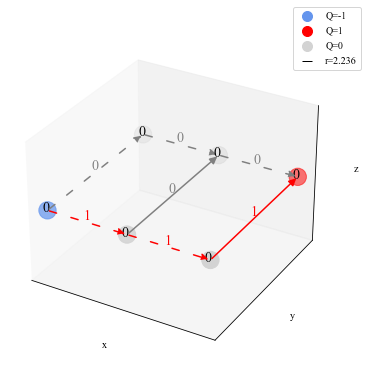

('1010101101', 0.2781975260958678)


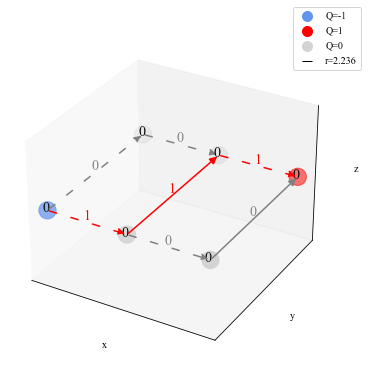

In [28]:
for key,val in {key:val for key,val in dict_eigst.items() if val>1e-1}.items():
    conf = class_H_oprt.eop_config_from_string(key)
    print((key,val))
    latt.draw_graph_func(gauss_law_fig=True,e_op_free=class_H_oprt.e_op_free,static_charges=qstat,weight=conf)#,savefig_dir='Images/',figname=f'config_g{g}_l{l}_E_0_VQD_{key}_probab{np.round(val,2)}.png')